<a href="https://colab.research.google.com/github/LionelAgo/Vortex_AE/blob/master/Vortex_TPU_ROM_conv3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages + Drive

1 - Install necessary package

2 - Import packages

3- mount drive

In [0]:
# - 2
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import h5py



# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.14.0'

In [0]:
# - 3
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
import os
dir="/content/drive/My Drive/Colab Notebooks/Vortex/"
os.chdir(dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Jet data + Preprocessing

## Load data 

In [0]:
f = h5py.File('Vortex.h5', 'r')

# List all groups
print("Keys: %s" % f.keys())
a = list(f.keys())[0] #U
tmp = list(f[a])
Om=np.array(tmp)         

a = list(f.keys())[1] #U
tmp = list(f[a])
S=np.array(tmp) 

a = list(f.keys())[2] #U
tmp = list(f[a])
U=np.array(tmp) 

a = list(f.keys())[3] #U
tmp = list(f[a])
V=np.array(tmp) 

del f
print(f'data downloaded')





Keys: KeysView(<HDF5 file "Vortex.h5" (mode r)>)
data downloaded


##  Prepare Data for Autoencoder 


1.   **Short window filtering by convoluting over 3 channels**

        - Keep coherent spatio-temporal structures over 3 timesteps
        
       *Remove incoherent noise -> speed up training process*
        
2.  **Feature scaling**

       - MinMaxScaler -> speed up training process
3. **Split the Data for training and validation**
      - multiple of 128 ( memory optimisation for TPU)
      - Temporel shift can be introduced between the input and ouput for reinforce the dynamic in Latent space


       
       





In [0]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 0.99))

def scaleC(tmp='U'):
  nt,nx,nz=np.shape(tmp)
  tmp=np.reshape(tmp,(nt,nx*nz))
  tmp=scaler.fit_transform(tmp.T)
  tmp=tmp.T
  tmp=np.reshape(tmp,(nt,nx,nz,1))
  #tmp=np.expand_dims(tmp,axis=4)
  tmp=tmp[:,2:-2,2:,:]
  return tmp

U=scaleC(U)
V=scaleC(V)
Om=scaleC(Om)
S=scaleC(S)
print(f'Database size_{np.shape(U)}')

Database size_(501, 256, 88, 1)


In [0]:
dt=16
tmp=U
nt,nx,nz,nc=np.shape(U)
tmp=tmp[:int(dt*np.floor(nt/dt)),:,:,:].reshape(int(np.floor(nt/dt)),dt,nx,nz,nc)

In [0]:


def data4AE3d(v,dt=8):

  nt,nx,nz,nc=np.shape(v) 
  for i in np.arange(0,dt):
    t=v[i:int(nt-dt+i),:,:,:]
    t=np.expand_dims(t,1)
    if i==0:
      tmp=t
    else:
      tmp=np.concatenate((tmp,t),axis=1)
  return tmp  

dt=16
Ut=data4AE3d(U,dt)


#Build Autoencoder (CCN)
   -  latent dimension define by : nl

In [0]:
#model=CAE_3L()
nl=4


def CAE_3L_conv(nl=int(nl)):
  
  nt,dt,nx,nz,nc=np.shape(Ut)
 
  filters=[8, 16, 32, nl]
  
  rate=0.0
  
  nm=8
  
  actd=lambda x: tf.nn.leaky_relu(x, alpha=0.2)
  #act=lambda x: tf.nn.crelu(x)
  #act='relu'
  act=lambda x: tf.nn.elu(x)

  input_shape=(dt,nx,nz, nc)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GaussianNoise(rate, input_shape=input_shape, name='noise'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv3D(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='conv1'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same'))

  model.add(tf.keras.layers.Conv3D(filters[1], (3,3,3), strides=1, activation=act, padding='same', name='conv2'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same'))

  model.add(tf.keras.layers.Conv3D(filters[2], (3,3,3), activation=act, padding='same', name='conv3'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same'))


  model.add(tf.keras.layers.Flatten())
  #model.add(tf.keras.layers.Dense(units=filters[3],activity_regularizer=tf.keras.regularizers.l1_l2(l1=10e-6,l2=10e-6), name='bottleneck'))
  model.add(tf.keras.layers.Dense(units=filters[3],activation=act, name='bottleneck'))

  model.add(tf.keras.layers.Dense(units=filters[2]*int(input_shape[0]/nm)*int(input_shape[1]/nm)*int(input_shape[2]/nm)))
  model.add(tf.keras.layers.Reshape((int(input_shape[0]/nm), int(input_shape[1]/nm), int(input_shape[2]/nm) , filters[2])))

  model.add(tf.keras.layers.UpSampling3D((2,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[2], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv3'))
  model.add(tf.keras.layers.UpSampling3D((2,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[1], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv2'))
  model.add(tf.keras.layers.UpSampling3D((2, 2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv1'))
  model.add(tf.keras.layers.Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same', name='last'))
  model.summary()

  
  return model

model=CAE_3L_conv()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 16, 256, 88, 1)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 256, 88, 1)    4         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 256, 88, 8)    1008      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 128, 44, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 8, 128, 44, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 64, 22, 16)     0         
____

## Define  loss functions

1.   **quantile_loss**  
     - q=0.5 similar to mean square error (similar to POD for linear activation function)
     - q<0.5 more accuracy for negative-fluctuation events
     - q>0.5 more accuracy for positive-fluctuation events
2.   **resemblance**

      - I created this function in order to measure the likeness between the original and predicted image.
      
                ***Rs*** factor is not weighted by energy and Rs<=1

     
    

In [0]:

def quantile_loss(y_true, y_pred):
    q=0.5 # similar to mae
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q*e, (q-1)*e), axis=-1)


def resemblance(y_true, y_pred):
    q=2
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return tf.reduce_mean(alp)
  
  

In [0]:

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.15.43.210:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9022426184326286521)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13450728020745672049)
INFO:tensorflow:*** 

In [0]:

with strategy.scope():
  model = CAE_3L_conv()
  model.compile(
      optimizer=tf.keras.optimizers.Adamax(),
      loss='logcosh',#resemblance,
      metrics=['mape'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 16, 256, 88, 1)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 256, 88, 1)    4         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 256, 88, 8)    1008      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 128, 44, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 8, 128, 44, 16)    3472      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 64, 22, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 4, 64, 22, 32)    

# Train and evaluate model


1.   Train
2.   Evaluate
3.  Save



In [0]:
#model=CAE_3L_conv()
namesave=f'Vs_{nl}dim_dt16'                
model.load_weights(namesave+'.h5')



history=model.fit(
          Ut[0:int(3*128),:,:,:,:].astype(np.float32), Ut[0:int(3*128),:,:,:,:].astype(np.float32),
          epochs=1024, #64
          steps_per_epoch=3, #batch size X1_tain[0]/steps_per_epoch  4 -> 1024,
          )

namesave=f'Vs_{nl}dim_dt16'               
model.save_weights(namesave+'.h5', overwrite=True)
print(f'Saved model to disk - {namesave}')


Epoch 1/1024
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
3/3 [==============================] - 36s 12s/step - loss: 0.0044 - mean_absolute_percentage_error: 10.7737
Epoch 2/1024
3/3 [==============================] - 12s 4s/step - loss: 0.0017 - mean_absolute_percentage_error: 7.5648
Epoch 3/1024
3/3 [==============================] - 12s 4s/step - loss: 0.0012 - mean_absolute_percentage_error: 6.4058
Epoch 4/1024
3/3 [==============================] - 12s 4s/step - loss: 7.7142e-04 - mean_absolute_percentage_error: 5.1045
Epoch 5/1024
3/3 [==============================] - 12s 4s/step - loss: 5.8146e-04 - mean_absolute_percentage_error: 4.3923
Epoch 6/1024
3/3 [==============================] - 12s 4s/step - loss: 4.3195e-04 - mean_absolute_percentage_error: 3.7257
Epoch 7/1024
3/3 [==============================] - 12s 4s/step - loss: 3.4472e-04 - mean_absolute_percentage_error: 3.3013
Epoch 8/1024
3/3 [==============================] - 12

**Plot  training history**

In [0]:
print(history.history.keys())


dict_keys(['loss', 'mean_absolute_percentage_error'])


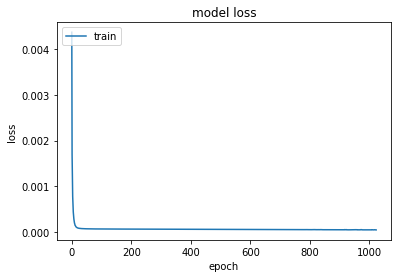

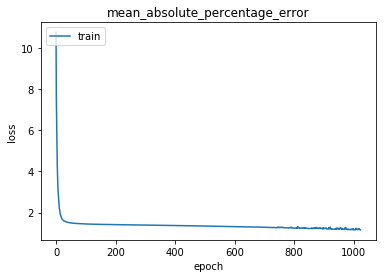

In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
#plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## evaluation model 

In [0]:

model.evaluate(Ut[-128:,:,:,:,:].astype(np.float32), Ut[-128:,:,:,:,:].astype(np.float32))
#np.shape(X1_val)

4/4 [==============================] - 19s 5s/step


[3.983706028520828e-05, 1.170653]

In [0]:

namesave=f'T100_{nl}dim'               
model.save_weights(namesave+'.h5', overwrite=True)
print(f'Saved model to disk - {namesave}')


Saved model to disk - T100_4dim


#Load model

In [0]:

model = CAE_3L_conv()

namesave=f'T100_{nl}dim'               
             
model.load_weights(namesave+'.h5')
print("model Loaded from disk")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 16, 256, 88, 1)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 256, 88, 1)    4         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 256, 88, 8)    1008      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 128, 44, 8)     0         
_________________________________________________________________
conv2 (Conv3D)               (None, 8, 128, 44, 16)    3472      
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 64, 22, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 4, 64, 22, 32)    

# Define Encoder - Decoder

In [0]:


# Encoder
encoder = tf.keras.Model(model.input, model.get_layer('bottleneck').output)


# Decoder
input_img = tf.keras.Input(shape=(nl,))

K=10
dec_1 = model.layers[int(K)]
dec_2 = model.layers[int(K+1)]
dec_3 = model.layers[int(K+2)]
dec_4 = model.layers[int(K+3)]
dec_5 = model.layers[int(K+4)]
dec_6 = model.layers[int(K+5)]
dec_7 = model.layers[int(K+6)]
dec_8 = model.layers[int(K+7)]
dec_9 = model.layers[int(K+8)]
#dec_10 = model.layers[int(K+9)]

decoder = tf.keras.Model(input_img, ((dec_9(dec_8(dec_7(dec_6(dec_5(dec_4(dec_3(dec_2(dec_1(input_img))))))))))))
#decoder_filter = tf.keras.Model(input_img, (dec_5(dec_4(dec_3(dec_2(dec_1(input_img)))))))
  

**Build a low dimensional representation of Snapshots -  Encoder**

In [0]:
X1=Ut[:,:,:,:,:].astype(np.float32)
Renc = model.predict(X1)

In [0]:

X1=Ut[:,:,:,:,:].astype(np.float32)
Zenc = encoder.predict(X1)
print(f'size_of_latent_dim_{np.shape(Zenc)}')

size_of_latent_dim_(485, 4)


**Reconstruct from latent space - Decoder**

In [0]:
Renc=decoder.predict(Zenc)
print(f'size_of_reconstructed_field_{np.shape(Renc)}')

size_of_reconstructed_field_(485, 16, 256, 88, 1)


**Visualisation**

In [0]:
def np_resemblance(y_true, y_pred):
    q=2
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return alp

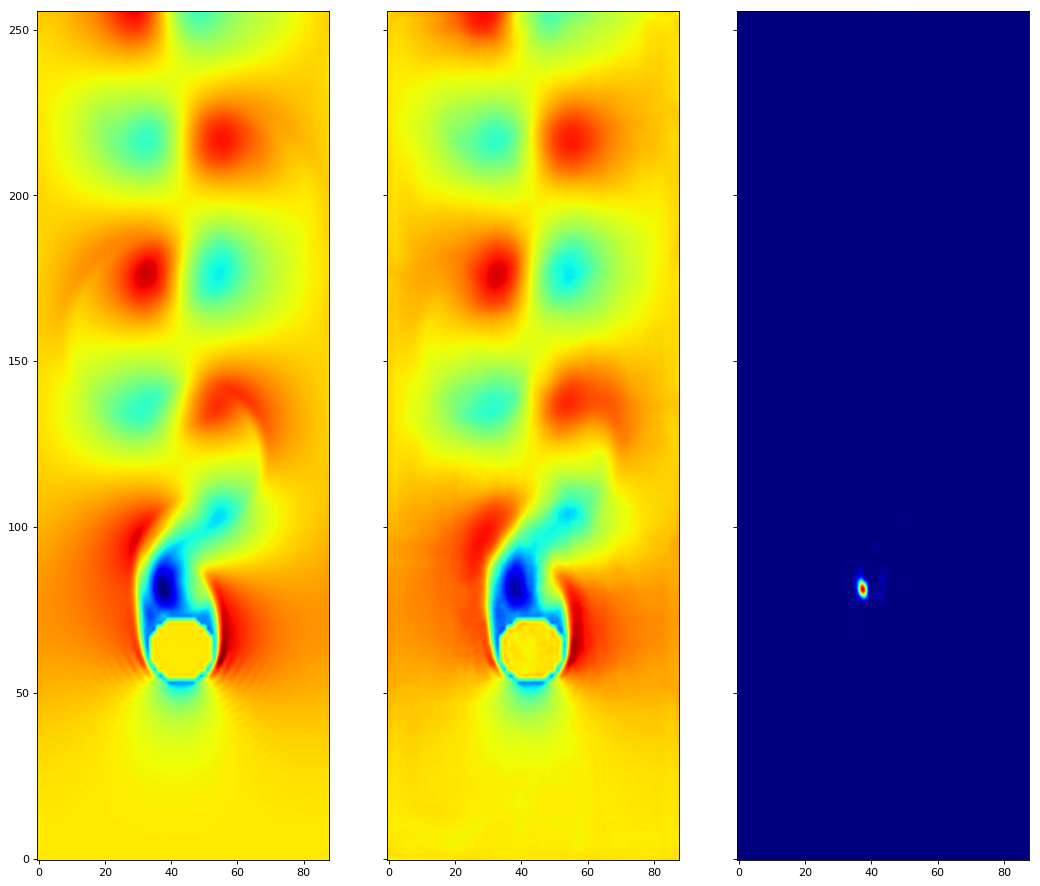

In [0]:
delta_t=0
dti=5
ni=np.random.randint(0,nt)
n=0
tmp=np.squeeze(X1[ni+delta_t,dti,:,:,n])
tmpi=np.squeeze(Renc[ni,dti,:,:,n])                


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
    
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
               
              
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')

alp=np_resemblance(tmp, tmpi)
z_min, z_max = alp.min(),alp.max()
ax3.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')

#print(f'{z_min}_{z_max}_mean_{np.mean(alp)}')



**Visualisations features map**

In [0]:
tmp=Zenc[ni,:]
tmp=np.expand_dims(tmp,axis=0)
features_map=decoder_filter.predict(np.expand_dims(Zenc[ni,:],axis=0))


zmin=features_map.min()    
zmax=features_map.max()    

f, ax = plt.subplots(4, 4, sharey=True,figsize=(8*2, 4), dpi=80, facecolor='w', edgecolor='k')

ix=0
for row in ax:
    for col in row:
      col.imshow(features_map[0,:, :, ix], cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', origin='lower')
      ix+=1
	

NameError: ignored

# Caracterisation of temporal relation of Latent components




## Spectral analysis of reduced



In [0]:
from scipy import signal

nt,nc=np.shape(Zenc)

_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fs=100/80
for i in range(nc):
    #print(i)
    data=Zenc[:,i]
   
    f, Pxx = signal.welch(data, fs, 'flattop', 1024/2, scaling='spectrum')
    #ax = plt.subplot(111)
    fPxx=f*Pxx
    tm=fPxx.max()
    
    ax.semilogx(1/f[1:], fPxx[1:], label=f'lat_dim = {i}')
    #ax.plot(1/f[1:]/(0.9), f[1:]*np.sqrt(Pxx[1:]), label=f'lat_dim = {i}')
    ax.set_xlim(1/f[-1],1/f[1])
    ax.legend()
    
    
    
    fPxx=fPxx/tm
    if i==0:
      FPxx=fPxx
    else:
      FPxx=np.vstack((FPxx,fPxx))
      
print(f'{np.shape(FPxx)}')      

In [0]:

_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ax.set_yscale('log')

tmp=FPxx[:,:].T

ax.pcolormesh(np.arange(0,nl+1), 1/f[1:], tmp[1:,:], cmap='jet')

ax.set_ylim(1/f[-1],1/f[1])



## Heatmap correlation

In [0]:
import seaborn as sns
corr = np.corrcoef(Zenc.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



_, ax = plt.subplots(1, 1, sharey=True,figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, square=True, cmap="seismic", cbar_kws={"shrink": .5})

## Coherence

In [0]:
n1,n2 = [int(x) for x in input("Enter two mode numbers here: ").split()]

dt = 0.2
fs=1/dt

s1 = Zenc[:,n1]
s2 = Zenc[:,n2]

xt=np.linspace(0,nt*dt,nt)

fig, axs = plt.subplots(2, 1)
axs[0].plot(xt, s1, xt, s2)
#axs[0].plot(xt, 20*s[0]*at[0,delta_t:],xt, 20*s[1]*at[1,delta_t:] )
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

win=2*256
f,cxy = signal.coherence(s1, s2, fs, nperseg=win ,noverlap = win // 2.)
axs[1].semilogx(1/f/(0.9), cxy)
#axs[1].semilogx(1/f,cxy)
axs[1].set_ylabel('coherence')
axs[1].set_xlim(0,100)

fig.tight_layout()
plt.show()    

## Joint Pdfs - showing no linear relation 

In [0]:
H, xedges, yedges = np.histogram2d(Zenc[:,n1], Zenc[:,n2], bins=(14,14))
#plt.imshow(H, interpolation='none', aspect='equal',origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.imshow(H, interpolation='spline16', aspect='equal', origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


#Proper orthogonal decompostion in Latent space


1.  **Proper orthogonal decompostion of Latent space**
     - Run POD in latent space (dimension 9xnT) : 9 eigenvectors (Vp_latent)
         -( *The 1st mode is almost a mean value produced by the scalin MinMaxScaler*)
   
    - Reconstruct fields from these 9 Vp_latents
   
2.   **Proper orthogonal decompostion of original field**

3. **Comparaison between both reconstructed field**
4. **Remarks**



## Proper orthogonal decompostion of Latent space

In [0]:
# -1 
nc=nl
u, s, vlat = np.linalg.svd(Zenc.T)
np.shape(u)

plt.plot(s[0:],'+-')

f, ax = plt.subplots(int(nc/2), 2, sharey=True,figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ix=0
for row in ax:
    for col in row:
      tmp=u[:,ix]
      tmp=np.reshape(tmp,(1,nc))
      tmp=decoder.predict(tmp)
      
      if ix==0:
        tmp1=u[:,0]
        tmp1=np.reshape(tmp1,(1,nc))
        tmp1=decoder.predict(tmp1)
      
      #tmp=tmp-tmp1
      
      zmin=1*tmp.min()
      zmax=1*tmp.max()
      col.imshow(np.squeeze(tmp[0,:,:,6,0]), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='auto', origin='low')
      ix+=1
print(ix)




## Proper orthogonal decompostion of original field

In [0]:
from sklearn.decomposition import PCA

pt=U[0:3*128,:,:,0]
nt,nr,nx=np.shape(pt)
ptmp=np.reshape(pt,[nt,nx*nr])

pca = PCA(n_components=nl)


pca = PCA(n_components=nl)
X_train_pca = pca.fit_transform(ptmp.T)

at=pca.components_
X1_pod = pca.inverse_transform(X_train_pca)
X1_pod=np.reshape(X1_pod,(nr,nx,-1))
X1_pod=np.transpose(X1_pod,(2,0,1))
X1_pod=np.expand_dims(X1_pod,axis=3)


X_train_pca = pca.fit_transform(ptmp)

s = pca.explained_variance_
plt.plot(s[:],'+-')


vp=pca.components_

vp=np.reshape(vp,(nc,nr,nx))
f, ax = plt.subplots(int(nc/2+0.5), 2, sharey=True,figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

ix=0
for row in ax:
    for col in row:
      
      tmp=np.squeeze(vp[ix,:,:])
      zmin=tmp.min()
      zmax=tmp.max()
      col.imshow(np.squeeze(tmp), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='auto', origin='low')
      ix+=1
print(ix)



##Comparaison between both reconstructed field




In [0]:
_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fs=1/0.2
for i in range(nc):
    #print(i)
    data=vlat[i,:]
   
    f, Pxx = signal.welch(data, fs, 'flattop', 1024/2, scaling='spectrum')
    #ax = plt.subplot(111)
    ax.semilogx(1/f[1:]/(0.9), f[1:]*(Pxx[1:]), label=f'lat_dim = {i}')
    #ax.set_xlim(1,30)
    ax.legend()
    ax.set_title('Premuliplied Power Spectra of temporel variation in Latent Space')
    
    
_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fs=1/0.2
for i in range(nc):
    #print(i)
    data=at[i,:]
   
    f, Pxx = signal.welch(data, fs, 'flattop', 1024/2, scaling='spectrum')
    #ax = plt.subplot(111)
    ax.semilogx(1/f[1:]/(0.9), f[1:]*(Pxx[1:]), label=f'POD_at = {i}')
    #ax.set_xlim(1,30)
    ax.legend()
    ax.set_title('Premuliplied Power Spectra of temporel variation from POD')   

In [0]:
ni=np.random.randint(0,nt)
n=0

 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
 
tmp=np.squeeze(U[ni+delta_t,:,:,n])  
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max,
              #extent=[x.min(), x.max(), r.min(), r.max()],
              interpolation='spline16', origin='lower')
ax1.set_title('original field')
               
              
tmp=np.squeeze(Renc[ni,0,:,:,n]) 
ax2.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max,
              #extent=[x.min(), x.max(), r.min(), r.max()],
              interpolation='spline16', origin='lower')
ax2.set_title('Reconstructed from Latent space')

#tmp=np.squeeze(p[ni,:,:,n]) 
#z_min, z_max = tmp.min(),tmp.max()
tmp=np.squeeze(X1_pod[ni,:,:,n])
ax3.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max,
              #extent=[x.min(), x.max(), r.min(), r.max()],
              interpolation='spline16', origin='lower')
ax3.set_title('Reconstructed from POD')

In [0]:
ix=0
n=0
VRenc=[]
VPod=[]
dp=Ut[:,0,:,:,:]
xl=range(0,88)

for ni in range(dp.shape[0]):
  ix +=1
  tmp=np.squeeze(dp[ni+delta_t,:,:,n])  
  tmp2=np.squeeze(Renc[ni,0,:,:,n]) 
  val=0
  val=np.mean(abs(tmp2[:,xl]**1 - tmp[:,xl]**1)/abs(tmp[:,xl]**1))
  #np.shape(val)
  if ix==1:
    VRenc=val
  else:
    VRenc=np.vstack((VRenc,val))


    
  
  #tmp=np.squeeze(p[ni,:,:,n]) 
  tmp=np.squeeze(dp[ni+delta_t,:,:,n])  
  if ni<384:
    tmp2=np.squeeze(X1_pod[ni,:,:,n])
    val=0
    val=np.mean(abs(tmp2[:,xl]**1 - tmp[:,xl]**1)/abs(tmp[:,xl]**1))
    if ix==1:
      VPod=val
    else:
      VPod=np.vstack((VPod,val))
  else:
    VPod=np.vstack((VPod,np.nan))
#tmp=np.squeeze(p[ni,:,:,n]) 

#tmp2=np.squeeze(X1_pod[ni,:,:,n])

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[:3*128],'r-')
ax.set_xlim(0,4*128)
#ax.set_ylim(0,0.2)

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(VPod,'b-')
ax.set_xlim(0,4*128)
#ax.set_ylim(0,0.2)

df={'AE':VRenc[0:4*128], 'POD':VPod}

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[0:3*128],'r-')
ax.plot(VPod,'b-')
ax.set_xlim(0,4*128)
#ax.set_ylim(0,0.2)





In [0]:
import seaborn as sns
import pandas as pd

df={'AE':VRenc[0:4*1024], 'POD':VPod}
df= pd.DataFrame([df])
sns.pairplot(df, hue="species")

# Prediction

In [0]:
X1=dp # multiple of 1024 for TPU optimization
X1=X1.reshape(int(dp.shape[0]/4),4,39,175,1)
Zenc = encoder.predict(X1)

scaler_Zenc = MinMaxScaler(feature_range=(0.01, 0.99))
Zencs=scaler_Zenc.fit_transform(Zenc)
#Zencs=Zencs.T

zt,nl=np.shape(Zencs)
pas=10
ZencT=np.zeros((zt-pas,9,1))
#ZencT=np.expand_dims(Zenc,2)
ix=0
for i in range(0,pas):
#  ix+=1
  tmp=Zencs[i:-(pas-i),:]
  tmp=np.expand_dims(tmp,2)
  ZencT=np.append(ZencT,tmp,axis=2)

Zenc_in=ZencT[0:9*128,:,0:int((pas+1)/2)]
Zenc_in=np.expand_dims(Zenc_in,3)
Zenc_out=ZencT[0:9*128,:,int((pas+1)/2):-1]
Zenc_out=np.expand_dims(Zenc_out,3)


In [0]:
def pred_latent():
  
  nt,nl,nT,nc=np.shape(Zenc_in)
  
  filters=[16,32, 64,  nl]
  
  #act=lambda x: tf.nn.leaky_relu(x, alpha=0.2)
  act=lambda x: tf.nn.crelu(x)
  #act='relu'

  input_shape=(nl, nT, nc)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters[0], (3), strides=1,dilation_rate=1, activation=act, padding='same', name='conv0',input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(filters[1], (3), strides=1,dilation_rate=1, activation=act, padding='same', name='conv1',input_shape=input_shape))
  model.add(tf.keras.layers.Conv2D(filters[2], (2), strides=1, activation=act, padding='same', name='conv2'))
  model.add(tf.keras.layers.Conv2DTranspose(filters[2], (2), strides=1, activation=act, padding='same', name='dconv2'))
  model.add(tf.keras.layers.Conv2DTranspose(filters[1], (3), strides=1, activation=act, padding='same', name='dconv1'))
  model.add(tf.keras.layers.Conv2DTranspose(filters[0], (3), strides=1, activation=act, padding='same', name='dconv0'))
  model.add(tf.keras.layers.Conv2DTranspose(nc, 2, activation='sigmoid', padding='same', name='last'))
  model.summary()
  return model


model=pred_latent()

In [0]:
del resolver
resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)



In [0]:

with strategy.scope():
  model2 = pred_latent()
  model2.compile(
       optimizer=tf.keras.optimizers.Adamax(),
       loss='logcosh',#resemblance,
       metrics=['mape'])

In [0]:

history=model2.fit(
        Zenc_in.astype(np.float32), Zenc_out.astype(np.float32),
        epochs=1000, #64
        steps_per_epoch=9, #batch size X1_tain[0]/steps_per_epoch   -> 128,
        )



In [0]:

ni=1200
X1o=X1[ni:ni+5,:,:,:,:]
Zenco = encoder.predict(X1o)

scaler_Zenco = MinMaxScaler(feature_range=(0.01, 0.99))
Zenco=scaler_Zenco.fit_transform(Zenco)
Zenco=Zenco.T
Zenco=np.expand_dims(Zenco,0)
Zenco=np.expand_dims(Zenco,3)

Zencp=model2.predict(Zenco)
#Zencp=scaler_Zenco.  
#Zenc_in 

In [0]:
zt,nl=np.shape(Zencs)
pas=10
ZencT=np.zeros((zt-pas,9,1))
#ZencT=np.expand_dims(Zenc,2)
ix=0
for i in range(0,pas):
#  ix+=1
  tmp=Zencs[i:-(pas-i),:]
  tmp=np.expand_dims(tmp,2)
  ZencT=np.append(ZencT,tmp,axis=2)

In [0]:
X1_ini=dp.reshape(int(4992/4),4,39,175,1)

ni=1200
Xio=X1_ini[ni,:,:,:,:]
Xio=np.expand_dims(Xio,0)
Zni=encoder(Xio)

In [0]:
Zp=model.predict(Zni)

# Remarks


*   Important point is that Autoencoder is not overfitting in order to keep the most general features
*   Similarities between Reconstruction from latent POD and POD, and AE seems to perform better times to times
*   one snapshot reconstruction from AE is one vector of 8 
*   one snapshot reconstruction from POD is 8 x 175x39 
*   Latent dimension is reduced by 98.5% compared to POD 

Reduction allows to:

1.   more effcient data clustering
2.   construct very low dimensional dynamic modal
3. coupled to reinforcement learning framework






#Clustering in Latent space

In [0]:
!pip install --upgrade git+git://github.com/scikit-learn-contrib/hdbscan.git
import hdbscan



In [0]:
from mpl_toolkits.mplot3d import Axes3D
import umap

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42
    )
    u = fit.fit_transform(Zenc);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=1)
    plt.title(title, fontsize=18)
    return u

In [0]:
#function plot fields reconstruct from clusters

def draw_modes(u,nc,pred,nc_proj=3):
  c='Set1'
  c='tab10'
  
  
  if nc_proj==3:
    fig = plt.figure(figsize=(27, 9))
    ax = fig.add_subplot(131, projection='3d')
    #ax.scatter(u[:,0], u[:,1], u[:,2], s=1, c=pred, cmap=c)
    ax.scatter(u[pred !=-1,0], u[pred !=-1,1], u[pred !=-1,2], s=1, c=pred[pred !=-1], cmap=c)
  
    ax = fig.add_subplot(132, projection='3d')
    #ax.scatter(u[:,1], u[:,2], u[:,0], s=1, c=pred, cmap=c)
    ax.scatter(u[pred !=-1,1], u[pred !=-1,2], u[pred !=-1,0], s=1, c=pred[pred !=-1], cmap=c)

      
    ax = fig.add_subplot(133, projection='3d')
    #pp=ax.scatter(u[:,2], u[:,0], u[p:,1], s=1, c=pred, cmap=c)
    pp=ax.scatter(u[pred !=-1,2], u[pred !=-1,0], u[pred !=-1,1], s=1, c=pred[pred !=-1], cmap=c)

    
    fig.colorbar(pp, orientation='horizontal')
  else:
    fig = plt.figure(figsize=(9, 9))
    pp=plt.scatter(u[pred !=-1,0], u[pred !=-1,1], s=1, c=pred[pred !=-1], cmap=c)
    fig.colorbar(pp, orientation='horizontal')


  f, ax = plt.subplots(int(nc/2+0.5), 2, sharey=True,figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

  ix=0
  for row in ax:
     for col in row:
        C=decoder.predict(Zenc[pred==ix])
        C=np.mean(C, axis=0)
        zmin=C.min()
        zmax=C.max()
        col.imshow(np.squeeze(C[:,:,0]), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
        ix+=1
  print(ix)
      


In [0]:
for n in (2, 5, 10, 20, 50, 100):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [0]:
u=draw_umap(n_neighbors=15, min_dist=0.0, n_components=2, metric='canberra')
#u=draw_umap(n_neighbors=15, min_dist=0.0, n_components=3, metric='canberra')

In [0]:
#import hdbscan


# k means determine k
num_c = []
K = range(50,250,10)
for k in K:
  hdb = hdbscan.HDBSCAN(min_cluster_size=k)#90
  pred_hdb = hdb.fit_predict(u)
  labels = hdb.labels_
  nc = len(set(labels)) - (1 if -1 in labels else 0)
  num_c.append(nc)

# Plot the elbow
plt.plot(K, num_c, 'bx-')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of clusters')
plt.show()

In [0]:

hdb = hdbscan.HDBSCAN(min_cluster_size=111)#90
pred_hdb = hdb.fit_predict(u)

labels = hdb.labels_
nc = len(set(labels)) - (1 if -1 in labels else 0)

print(f'numbers of cluster {nc}')

#plt.plot(pred_hdb,'+-')




In [0]:
draw_modes(u,nc,pred_hdb,2)

# Graph of Markov Chain

In [0]:
pred=pred_hdb[pred_hdb>-1]

H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=(nc))

H=H*100/nt
ns=np.diag(H)

plt.bar(np.arange(0,nc),ns)



In [0]:
import seaborn as sns
Ht=H
np.fill_diagonal(Ht,0)
Ht=100*Ht/np.sum(Ht)

_, ax = plt.subplots(1, 1, sharey=True,figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
zmax=Ht.max()


#with sns.axes_style("white"):
#    ax = sns.heatmap(H,  annot=True, vmin=0, vmax=zmax, square=True, cmap="seismic", linewidths=.5)
    
mask = np.zeros_like(Ht)
mask[np.diag_indices_from(mask)] = True
A=np.round(Ht,1)
A[A<1.5]=0
mask[np.where(A==0)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Ht, mask=mask,  annot=True,  square=True, cmap="jet", linewidths=.5)
    ax.set_facecolor((0.9,0.9,0.9))

In [0]:
import networkx as nx
temp=nx.MultiDiGraph()


G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)


_, ax = plt.subplots(1, 1, sharey=True,figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=(nc))
H=H*100/nt
ns=np.diag(H)

layout = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos=layout, node_size=150*ns, alpha=0.5, node_color='gray')
nx.draw_networkx_labels(G, pos=layout, font_size=20, font_family='sans-serif')

epline=np.reshape(A,np.size(A))
epline=epline[epline>0]


edges = nx.draw_networkx_edges(G, pos=layout, node_size=150*ns, linestyle='.', arrowstyle='-|>',
                               arrowsize=40,  edge_color=epline,edge_alphas=0.5,
                               edge_cmap=plt.cm.jet, 
                               width=epline)

#edges = nx.draw_networkx_edges(G, pos=layout, linestyle='.', arrowstyle='-|>',
#                               arrowsize=40,  edge_color=epline,edge_alphas=0.5,
#                               edge_cmap=plt.cm.jet, 
#                               width=epline)


#plt.show()





      


In [0]:
f, ax = plt.subplots(int(nc/2+0.5), 2, sharey=True,figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

ix=0
for row in ax:
    for col in row:
      C=decoder.predict(Zenc[pred_hdb==ix])
      C=np.mean(C, axis=0)
      zmin=C.min()
      zmax=C.max()
      col.imshow(np.squeeze(C[:,:,0]), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
      col.set_title('mode: %i' %ix)
      ix+=1

In [0]:
_, ax = plt.subplots(1, 1, sharey=True,figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
prms=np.var(p,0)
zmin, zmax = prms.min(),prms.max()
plt.imshow(np.squeeze(prms[:,:,0]), extent=[x.min(), x.max(), r.min(), r.max()], cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
xin=110
rin=20
plt.plot(x[rin,xin],r[rin,xin], 'w+')
Pabs=p[0:nt,rin,xin,0] 
Pabs=np.expand_dims(Pabs,1)

In [0]:
un=np.append(u,Pabs,1)

In [0]:
fig = plt.figure(figsize=(9, 9))
pp=plt.scatter(un[:,1], un[:,2], s=1)


In [0]:
hdb = hdbscan.HDBSCAN(min_cluster_size=111)#90
pred_hdb = hdb.fit_predict(un)

labels = hdb.labels_
nc = len(set(labels)) - (1 if -1 in labels else 0)

print(f'numbers of cluster {nc}')

In [0]:
draw_modes(un,nc,pred_hdb,3)

# Others Clusters methods

In [0]:
from sklearn import manifold

#tsne = manifold.TSNE(n_components=3, perplexity=5.0, random_state=10)
#X_tsne = tsne.fit_transform(Zenc)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 1])
plt.show()



In [0]:
from sklearn.cluster import DBSCAN

db=DBSCAN(eps=0.4, min_samples=130)
pred_db=db.fit_predict(u)
labels = db.labels_
nc = len(set(labels)) - (1 if -1 in labels else 0)

print(f'numbers of cluster {nc}')

plt

In [0]:
draw_modes(u,9,pred_db)

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,20)
for k in K:
   
    km = KMeans(init='k-means++',n_clusters=k, random_state=100)
    pred_km= km.fit_predict(u)
    distortions.append(sum(np.min(cdist(u, km.cluster_centers_, 'euclidean'), axis=1)) / u.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:

from sklearn.cluster import KMeans,SpectralClustering

nc=7

km = KMeans(init='k-means++',n_clusters=nc, random_state=10)
pred_km= km.fit_predict(Zenc)

sm = SpectralClustering(n_clusters=nc, affinity='nearest_neighbors', assign_labels='kmeans')
pred_sm = sm.fit_predict(Zenc)




In [0]:
draw_modes(u,nc,pred_km)

In [0]:
draw_modes(u,nc,pred_sm)

# Markov process and Probability

In [0]:
pred=pred_db
np.shape(pred)
plt.plot(pred[0:1000],'+-')
#pred_db[1:10]

#plt.hist(pred)


In [0]:
pred=pred_db
H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=(n_clusters_), density='sample_count')

H=H*100

_, ax = plt.subplots(1, 1, sharey=True,figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
zmax=H.max()



with sns.axes_style("white"):
    ax = sns.heatmap(H,  annot=True, vmin=0, vmax=zmax, square=True, cmap="seismic", linewidths=.5)


In [0]:
pred=pred_sm
H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=([n_clusters_]), density='sample_count')
#plt.imshow(H, interpolation='none', aspect='equal',origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

H=H*100
xedges=xedges+0.5
yedges=yedges+0.5


plt.imshow(H, aspect='equal', origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


